# MMR Reranking: Maximal Marginal Relevance (MMR) Reranking

## 🎯 Objectives

In this notebook, you'll learn:
- What Maximal Marginal Relevance (MMR) is and why it matters
- How to implement MMR reranking to reduce redundancy
- When MMR helps vs when it can hurt search quality
- How to tune the λ parameter for different query types
- Measuring diversity vs relevance trade-offs
- Applying MMR to both dense and hybrid search results

## 📋 Prerequisites

- This notebook creates its own collection (hybrid search)
- Understanding of vector similarity and search results
- Basic linear algebra (cosine similarity, vector operations)

In [1]:
import os
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt
from collections import defaultdict
import time

from utils import (
    get_qdrant_client, create_sample_dataset, search_dense, 
    search_hybrid_fusion, mmr_rerank, print_search_results,
    calculate_redundancy, print_system_info
)

from qdrant_client.models import VectorParams, Distance

print_system_info()
print("\n🎯 MMR Reranking Workshop")

/Users/thierrydamiba/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


🔧 System Information:
   Python: 3.9.6
   ✅ Qdrant Client: unknown
   ✅ NumPy: 1.26.4
   ✅ Pandas: 2.2.2
   ✅ Matplotlib: 3.9.4


   ✅ Scikit-learn: 1.6.1

🔧 Optional Dependencies:
   ✅ FastEmbed: 0.5.0
   ✅ OpenAI: 1.100.1


   ✅ Anthropic: 0.57.1

🔬 Environment: JupyterLab/Notebook detected

🎯 MMR Reranking Workshop


## 📦 Install Dependencies (if needed)

In [2]:
# Uncomment if running in a fresh environment
# !pip install qdrant-client numpy pandas matplotlib scikit-learn

## ⚙️ Setup & Configuration

In [3]:
# Configuration & Data Setup (independent)
from utils import (
    get_qdrant_client,
    ensure_collection,
    create_sample_dataset,
    upsert_points_batch,
    search_dense,
    search_hybrid_fusion,
)
from qdrant_client.models import VectorParams, Distance
import numpy as np

COLLECTION_NAME = "workshop_mmr"
active_collection = COLLECTION_NAME

# Connect to Qdrant
client = get_qdrant_client()

# Ensure collection exists and has data
try:
    info = client.get_collection(active_collection)
except Exception:
    info = None

needs_population = False
if info is None:
    needs_population = True
else:
    try:
        needs_population = int(getattr(info, 'points_count', 0) or 0) == 0
    except Exception:
        needs_population = False

if needs_population:
    print(f"✅ Creating and populating demo collection: {active_collection}")
    ensure_collection(
        client,
        active_collection,
        VectorParams(size=384, distance=Distance.COSINE),
        force_recreate=True,
    )
    df = create_sample_dataset(size=200, seed=42)
    vectors = np.random.randn(len(df), 384)
    vectors = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)
    upsert_points_batch(
        client,
        active_collection,
        df,
        vectors,
        ["text", "category", "lang", "timestamp"],
        batch_size=100,
    )
    print(f"✅ Added {len(df)} documents to {active_collection}")
else:
    print(f"✅ Using existing collection: {active_collection}")

🌐 Using Qdrant Cloud cluster: https://a025094c-936b-4e1b-b947-67d686d20306.eu-central-1-0.aws.development-cloud.qdrant.io:6333


✅ Using existing collection: workshop_mmr


## 🧠 MMR Theory & Intuition

### What is Maximal Marginal Relevance?

MMR balances two competing objectives:
1. **Relevance**: How well does each item match the query?
2. **Diversity**: How different is each item from already selected items?

**MMR Score = λ × Relevance - (1-λ) × Max_Similarity_to_Selected**

Where:
- λ ∈ [0,1]: Controls relevance vs diversity trade-off
- λ = 1: Pure relevance (no diversity)
- λ = 0: Pure diversity (no relevance)
- λ = 0.5: Balanced approach

In [4]:
def explain_mmr_visually():
    """Visual explanation of MMR concept"""
    print("🎯 MMR Intuition Example")
    print("=" * 40)
    
    print("\n📍 Scenario: Query 'machine learning'")
    print("\n🔍 Top 5 similarity results (without MMR):")
    print("   1. [0.95] Machine learning algorithms and techniques")
    print("   2. [0.94] ML algorithms for data science")
    print("   3. [0.93] Machine learning model training")
    print("   4. [0.92] Supervised machine learning methods")
    print("   5. [0.91] ML classification and regression")
    
    print("\n❌ Problem: All results are very similar!")
    print("   • High relevance but low diversity")
    print("   • User gets repetitive information")
    print("   • Misses broader context")
    
    print("\n✅ With MMR (λ=0.5):")
    print("   1. [0.95] Machine learning algorithms and techniques")
    print("   2. [0.85] Neural network architecture patterns")
    print("   3. [0.82] Data preprocessing for ML pipelines")
    print("   4. [0.79] ML model deployment strategies")
    print("   5. [0.76] Performance metrics and evaluation")
    
    print("\n✅ Benefits:")
    print("   • Still relevant to 'machine learning'")
    print("   • Covers different aspects of ML")
    print("   • More informative for users")
    print("   • Better coverage of the domain")

explain_mmr_visually()

🎯 MMR Intuition Example

📍 Scenario: Query 'machine learning'

🔍 Top 5 similarity results (without MMR):
   1. [0.95] Machine learning algorithms and techniques
   2. [0.94] ML algorithms for data science
   3. [0.93] Machine learning model training
   4. [0.92] Supervised machine learning methods
   5. [0.91] ML classification and regression

❌ Problem: All results are very similar!
   • High relevance but low diversity
   • User gets repetitive information
   • Misses broader context

✅ With MMR (λ=0.5):
   1. [0.95] Machine learning algorithms and techniques
   2. [0.85] Neural network architecture patterns
   3. [0.82] Data preprocessing for ML pipelines
   4. [0.79] ML model deployment strategies
   5. [0.76] Performance metrics and evaluation

✅ Benefits:
   • Still relevant to 'machine learning'
   • Covers different aspects of ML
   • More informative for users
   • Better coverage of the domain


## 🔍 Get Baseline Search Results

Let's get a large set of candidates to rerank with MMR.

In [5]:
def create_diverse_queries() -> List[Dict]:
    """Create queries that benefit from MMR in different ways"""
    queries = [
        # Ambiguous queries (should benefit from MMR)
        {
            "text": "optimization",
            "type": "ambiguous",
            "description": "Could mean database, algorithm, or business optimization"
        },
        {
            "text": "configuration setup", 
            "type": "ambiguous",
            "description": "Could apply to various systems and tools"
        },
        # Specific queries (might be hurt by high diversity)
        {
            "text": "password reset procedure",
            "type": "specific",
            "description": "Very specific need, diversity might hurt"
        },
        {
            "text": "HNSW algorithm implementation",
            "type": "specific", 
            "description": "Technical and specific"
        },
        # Broad queries (should benefit from MMR)
        {
            "text": "customer support help",
            "type": "broad",
            "description": "Broad topic with many subtypes"
        },
        {
            "text": "software development process",
            "type": "broad",
            "description": "Wide domain with many aspects"
        }
    ]
    
    return queries

# Create test queries
test_queries = create_diverse_queries()

print("🎯 Test Queries for MMR Analysis:")
for i, query in enumerate(test_queries, 1):
    print(f"{i}. [{query['type']:>10}] '{query['text']}'")
    print(f"   💭 {query['description']}")
    print()

🎯 Test Queries for MMR Analysis:
1. [ ambiguous] 'optimization'
   💭 Could mean database, algorithm, or business optimization

2. [ ambiguous] 'configuration setup'
   💭 Could apply to various systems and tools

3. [  specific] 'password reset procedure'
   💭 Very specific need, diversity might hurt

4. [  specific] 'HNSW algorithm implementation'
   💭 Technical and specific

5. [     broad] 'customer support help'
   💭 Broad topic with many subtypes

6. [     broad] 'software development process'
   💭 Wide domain with many aspects



## 🔄 Baseline Search Function

Get initial candidates for MMR reranking.

In [6]:
from typing import List, Tuple, Dict
import numpy as np

# Baseline candidate retrieval (independent and robust)
def get_baseline_candidates(query_text: str, limit: int = 50) -> Tuple[List, np.ndarray, np.ndarray]:
    """Get baseline search results and vectors for MMR reranking.
    Falls back gracefully if vectors are missing.
    """
    global client, active_collection

    # Inspect vector config
    collection_info = client.get_collection(active_collection)
    vector_config = collection_info.config.params.vectors
    is_hybrid = isinstance(vector_config, dict) and "text_dense" in vector_config

    if is_hybrid:
        # Hybrid: use mock dense/sparse for demo
        dense_vector = np.random.randn(384)
        dense_vector /= np.linalg.norm(dense_vector)
        words = query_text.lower().split()
        sparse_vector = {i: 1.0 / max(1, len(words)) for i in range(len(words))}

        results = search_hybrid_fusion(
            client=client,
            collection_name=active_collection,
            dense_vector=dense_vector,
            sparse_vector=sparse_vector,
            dense_weight=0.6,
            limit=limit * 2,
            final_limit=limit,
        )

        point_ids = [r.id for r in results]
        points = client.retrieve(
            collection_name=active_collection,
            ids=point_ids,
            with_vectors=["text_dense"],
        )
        candidate_vectors = []
        for p in points:
            if getattr(p, "vector", None) and "text_dense" in p.vector:
                candidate_vectors.append(p.vector["text_dense"])
            else:
                v = np.random.randn(384)
                candidate_vectors.append(v / np.linalg.norm(v))
        candidate_vectors = np.array(candidate_vectors)
        query_vector = dense_vector
    else:
        # Single-vector collection
        vec_size = int(getattr(vector_config, "size", 384) or 384)
        query_vector = np.random.randn(vec_size)
        query_vector /= np.linalg.norm(query_vector)

        results = search_dense(
            client=client,
            collection_name=active_collection,
            query_vector=query_vector,
            limit=limit,
            with_payload=True,
            with_vectors=True,
        )

        candidate_vectors = []
        for r in results:
            vec = None
            if hasattr(r, "vector") and r.vector is not None:
                if isinstance(r.vector, dict):
                    vec = next(iter(r.vector.values()))
                else:
                    vec = r.vector
            if vec is None:
                v = np.random.randn(vec_size)
                vec = v / np.linalg.norm(v)
            candidate_vectors.append(vec)
        candidate_vectors = np.array(candidate_vectors)

    print(f"📊 Retrieved {len(results)} candidates with {candidate_vectors.shape[1]}D vectors")
    return results, candidate_vectors, query_vector

## 🎯 Implement MMR Reranking

Now let's apply MMR to rerank our candidates.

In [7]:
# MMR implementation is already in utils.py, let's test it

def compare_mmr_results(query_text: str, lambda_values: List[float] = [0.2, 0.5, 0.8], k: int = 10):
    """Compare MMR results with different lambda values"""
    print(f"\n🎯 MMR Comparison: '{query_text}'")
    print("=" * 60)
    
    # Get baseline candidates
    candidates, candidate_vectors, query_vector = get_baseline_candidates(query_text, limit=50)
    
    if len(candidates) == 0:
        print("⚠️ No candidates found")
        return
    
    results_by_lambda = {}
    
    # Original ranking (no MMR)
    original_top_k = candidates[:k]
    results_by_lambda['original'] = original_top_k
    
    print(f"\n🔍 ORIGINAL (No MMR):")
    for i, result in enumerate(original_top_k[:5]):
        print(f"  {i+1}. [{result.score:.3f}] {result.payload['text'][:55]}...")
    
    # Calculate original redundancy
    original_texts = [r.payload['text'] for r in original_top_k]
    original_redundancy = calculate_redundancy(original_texts)
    print(f"     📊 Redundancy: {original_redundancy:.3f}")
    
    # MMR with different lambda values
    for lambda_val in lambda_values:
        print(f"\n🎚️ MMR (λ={lambda_val}):")
        
        mmr_results = mmr_rerank(
            query_vector=query_vector,
            candidate_vectors=candidate_vectors[:len(candidates)],
            candidate_results=candidates,
            lambda_param=lambda_val,
            k=k
        )
        
        results_by_lambda[lambda_val] = mmr_results
        
        for i, result in enumerate(mmr_results[:5]):
            print(f"  {i+1}. [{result.score:.3f}] {result.payload['text'][:55]}...")
        
        # Calculate MMR redundancy
        mmr_texts = [r.payload['text'] for r in mmr_results]
        mmr_redundancy = calculate_redundancy(mmr_texts)
        
        # Calculate category diversity
        categories = [r.payload.get('category', 'unknown') for r in mmr_results]
        unique_categories = len(set(categories))
        category_diversity = unique_categories / len(categories) if categories else 0
        
        print(f"     📊 Redundancy: {mmr_redundancy:.3f} (vs {original_redundancy:.3f} original)")
        print(f"     📂 Category diversity: {category_diversity:.3f} ({unique_categories}/{len(categories)} unique)")
        
        # Show improvement
        if mmr_redundancy < original_redundancy:
            improvement = (original_redundancy - mmr_redundancy) / original_redundancy * 100
            print(f"     ✅ {improvement:.1f}% redundancy reduction")
    
    return results_by_lambda

# Test MMR on our first query
mmr_comparison = compare_mmr_results(test_queries[0]["text"])


🎯 MMR Comparison: 'optimization'


📊 Retrieved 50 candidates with 384D vectors

🔍 ORIGINAL (No MMR):
  1. [0.118] Guide: How do I cancel my subscription?...
  2. [0.113] Learn about what payment methods do you accept?...
  3. [0.106] Running automated tests...
  4. [0.106] Integration with popular tools - Updated version...
  5. [0.103] How do I reset my password?...
     📊 Redundancy: 0.031

🎚️ MMR (λ=0.2):
  1. [0.118] Guide: How do I cancel my subscription?...
  2. [0.113] Learn about what payment methods do you accept?...
  3. [0.106] Running automated tests...
  4. [0.095] Guide: New API endpoints available...
  5. [0.088] Guide: User content moderation rules...
     📊 Redundancy: 0.052 (vs 0.031 original)
     📂 Category diversity: 0.500 (5/10 unique)

🎚️ MMR (λ=0.5):
  1. [0.118] Guide: How do I cancel my subscription?...
  2. [0.113] Learn about what payment methods do you accept?...
  3. [0.106] Running automated tests...
  4. [0.095] Guide: New API endpoints available...
  5. [0.088] Guide: User content modera

## 📊 Comprehensive MMR Analysis

Let's analyze MMR performance across all our test queries.

In [8]:
def analyze_mmr_performance(queries: List[Dict], lambda_values: List[float] = [0.2, 0.5, 0.8]):
    """Comprehensive MMR analysis across multiple queries"""
    analysis_results = []
    
    for query in queries:
        print(f"\n🔍 Analyzing: '{query['text']}' ({query['type']})")
        
        try:
            # Get candidates
            candidates, candidate_vectors, query_vector = get_baseline_candidates(
                query["text"], limit=30
            )
            
            if len(candidates) < 5:
                print(f"   ⚠️ Insufficient candidates ({len(candidates)})")
                continue
            
            k = min(10, len(candidates))
            original_results = candidates[:k]
            
            # Calculate baseline metrics
            original_texts = [r.payload['text'] for r in original_results]
            original_redundancy = calculate_redundancy(original_texts)
            
            original_categories = [r.payload.get('category', 'unknown') for r in original_results]
            original_category_diversity = len(set(original_categories)) / len(original_categories)
            original_top_score = original_results[0].score if original_results else 0
            
            query_analysis = {
                'query': query['text'],
                'type': query['type'],
                'original_redundancy': original_redundancy,
                'original_category_diversity': original_category_diversity,
                'original_top_score': original_top_score
            }
            
            # Test different lambda values
            for lambda_val in lambda_values:
                mmr_results = mmr_rerank(
                    query_vector=query_vector,
                    candidate_vectors=candidate_vectors[:len(candidates)],
                    candidate_results=candidates,
                    lambda_param=lambda_val,
                    k=k
                )
                
                # Calculate MMR metrics
                mmr_texts = [r.payload['text'] for r in mmr_results]
                mmr_redundancy = calculate_redundancy(mmr_texts)
                
                mmr_categories = [r.payload.get('category', 'unknown') for r in mmr_results]
                mmr_category_diversity = len(set(mmr_categories)) / len(mmr_categories)
                mmr_top_score = mmr_results[0].score if mmr_results else 0
                
                # Calculate overlaps with original
                original_ids = {r.id for r in original_results}
                mmr_ids = {r.id for r in mmr_results}
                overlap_ratio = len(original_ids & mmr_ids) / len(original_ids)
                
                # Store results
                query_analysis[f'mmr_{lambda_val}_redundancy'] = mmr_redundancy
                query_analysis[f'mmr_{lambda_val}_category_diversity'] = mmr_category_diversity
                query_analysis[f'mmr_{lambda_val}_top_score'] = mmr_top_score
                query_analysis[f'mmr_{lambda_val}_overlap'] = overlap_ratio
                
                redundancy_change = (original_redundancy - mmr_redundancy) / original_redundancy * 100 if original_redundancy > 0 else 0
                query_analysis[f'mmr_{lambda_val}_redundancy_improvement'] = redundancy_change
                
                print(f"   λ={lambda_val}: redundancy {redundancy_change:+.1f}%, diversity {mmr_category_diversity:.2f}, overlap {overlap_ratio:.2f}")
            
            analysis_results.append(query_analysis)
            
        except Exception as e:
            print(f"   ❌ Error analyzing query: {e}")
    
    return analysis_results

# Run comprehensive analysis
print("🚀 Running comprehensive MMR analysis...")
analysis_results = analyze_mmr_performance(test_queries)

# Create summary DataFrame
if analysis_results:
    results_df = pd.DataFrame(analysis_results)
    print(f"\n📊 Analysis complete: {len(results_df)} queries analyzed")
else:
    print("⚠️ No analysis results generated")

🚀 Running comprehensive MMR analysis...

🔍 Analyzing: 'optimization' (ambiguous)


📊 Retrieved 30 candidates with 384D vectors
   λ=0.2: redundancy +12.9%, diversity 0.40, overlap 0.40
   λ=0.5: redundancy -39.5%, diversity 0.40, overlap 0.60
   λ=0.8: redundancy -23.8%, diversity 0.40, overlap 0.80

🔍 Analyzing: 'configuration setup' (ambiguous)


📊 Retrieved 30 candidates with 384D vectors
   λ=0.2: redundancy -90.9%, diversity 0.50, overlap 0.30
   λ=0.5: redundancy -58.8%, diversity 0.50, overlap 0.50
   λ=0.8: redundancy -65.7%, diversity 0.50, overlap 0.90

🔍 Analyzing: 'password reset procedure' (specific)


📊 Retrieved 30 candidates with 384D vectors
   λ=0.2: redundancy +8.8%, diversity 0.40, overlap 0.70
   λ=0.5: redundancy +36.2%, diversity 0.40, overlap 0.50
   λ=0.8: redundancy +57.5%, diversity 0.50, overlap 0.80

🔍 Analyzing: 'HNSW algorithm implementation' (specific)


📊 Retrieved 30 candidates with 384D vectors
   λ=0.2: redundancy +48.6%, diversity 0.50, overlap 0.50
   λ=0.5: redundancy +50.6%, diversity 0.50, overlap 0.50
   λ=0.8: redundancy -1.1%, diversity 0.50, overlap 0.80

🔍 Analyzing: 'customer support help' (broad)


📊 Retrieved 30 candidates with 384D vectors
   λ=0.2: redundancy -212.2%, diversity 0.40, overlap 0.40
   λ=0.5: redundancy -52.2%, diversity 0.40, overlap 0.50
   λ=0.8: redundancy +15.8%, diversity 0.50, overlap 0.90

🔍 Analyzing: 'software development process' (broad)


📊 Retrieved 30 candidates with 384D vectors
   λ=0.2: redundancy +3.2%, diversity 0.50, overlap 0.50
   λ=0.5: redundancy -8.4%, diversity 0.50, overlap 0.60
   λ=0.8: redundancy -8.7%, diversity 0.40, overlap 0.90

📊 Analysis complete: 6 queries analyzed


## 📈 MMR Performance Visualization

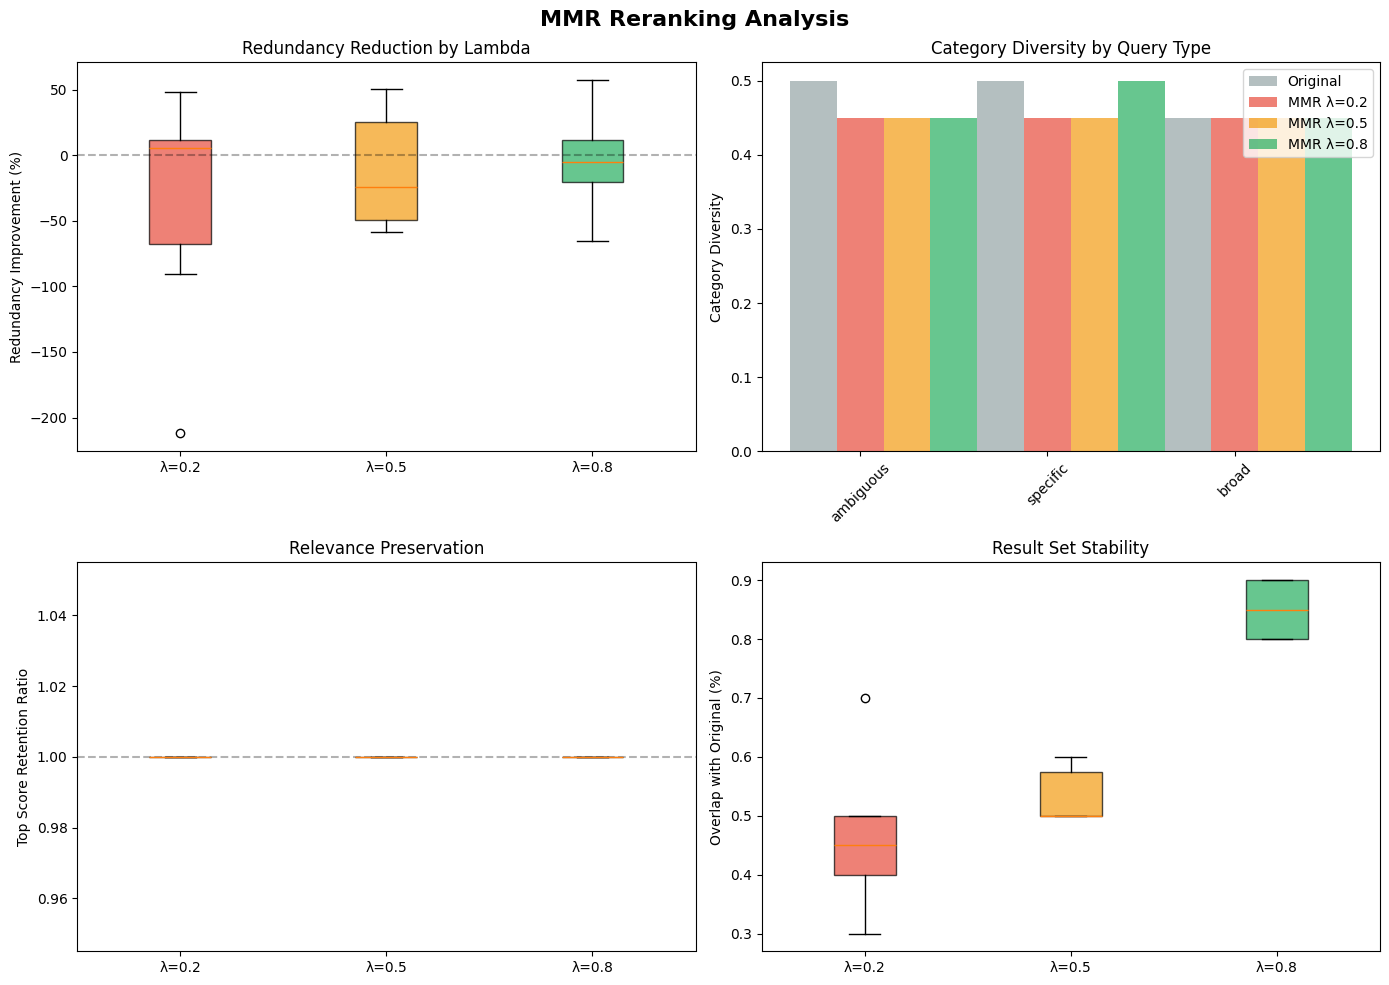


📊 MMR Analysis Summary:

λ=0.2:
   📉 Avg redundancy reduction: -38.3%
   📈 Avg diversity improvement: -6.9%
   🔄 Avg result overlap: 46.7%

λ=0.5:
   📉 Avg redundancy reduction: -12.0%
   📈 Avg diversity improvement: -6.9%
   🔄 Avg result overlap: 53.3%

λ=0.8:
   📉 Avg redundancy reduction: -4.3%
   📈 Avg diversity improvement: -3.4%
   🔄 Avg result overlap: 85.0%


In [9]:
if 'results_df' in locals() and len(results_df) > 0:
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('MMR Reranking Analysis', fontsize=16, fontweight='bold')
    
    lambda_values = [0.2, 0.5, 0.8]
    colors = ['#e74c3c', '#f39c12', '#27ae60']  # Red, Orange, Green
    
    # 1. Redundancy Improvement by Lambda
    ax1 = axes[0, 0]
    lambda_improvements = []
    for lam in lambda_values:
        col = f'mmr_{lam}_redundancy_improvement'
        if col in results_df.columns:
            improvements = results_df[col].values
            lambda_improvements.append(improvements)
    
    if lambda_improvements:
        positions = np.arange(len(lambda_values))
        bp = ax1.boxplot(lambda_improvements, positions=positions, patch_artist=True)
        
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax1.set_xticklabels([f'λ={lam}' for lam in lambda_values])
        ax1.set_ylabel('Redundancy Improvement (%)')
        ax1.set_title('Redundancy Reduction by Lambda')
        ax1.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    
    # 2. Category Diversity Improvement
    ax2 = axes[0, 1]
    query_types = results_df['type'].unique()
    x_pos = np.arange(len(query_types))
    width = 0.25
    
    original_diversity = []
    mmr_diversity_by_lambda = {lam: [] for lam in lambda_values}
    
    for qtype in query_types:
        subset = results_df[results_df['type'] == qtype]
        original_diversity.append(subset['original_category_diversity'].mean())
        
        for lam in lambda_values:
            col = f'mmr_{lam}_category_diversity'
            if col in subset.columns:
                mmr_diversity_by_lambda[lam].append(subset[col].mean())
            else:
                mmr_diversity_by_lambda[lam].append(0)
    
    # Plot bars
    ax2.bar(x_pos - width, original_diversity, width, label='Original', color='#95a5a6', alpha=0.7)
    
    for i, lam in enumerate(lambda_values):
        ax2.bar(x_pos + (i * width), mmr_diversity_by_lambda[lam], width, 
               label=f'MMR λ={lam}', color=colors[i], alpha=0.7)
    
    ax2.set_ylabel('Category Diversity')
    ax2.set_title('Category Diversity by Query Type')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(query_types, rotation=45)
    ax2.legend()
    
    # 3. Top Score Preservation
    ax3 = axes[1, 0]
    score_ratios_by_lambda = []
    
    for lam in lambda_values:
        score_col = f'mmr_{lam}_top_score'
        if score_col in results_df.columns:
            # Calculate score retention ratio
            score_ratios = results_df[score_col] / results_df['original_top_score']
            score_ratios = score_ratios[np.isfinite(score_ratios)]  # Remove inf/nan
            score_ratios_by_lambda.append(score_ratios)
    
    if score_ratios_by_lambda:
        bp2 = ax3.boxplot(score_ratios_by_lambda, patch_artist=True)
        for patch, color in zip(bp2['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax3.set_xticklabels([f'λ={lam}' for lam in lambda_values])
        ax3.set_ylabel('Top Score Retention Ratio')
        ax3.set_title('Relevance Preservation')
        ax3.axhline(y=1.0, color='black', linestyle='--', alpha=0.3, label='Perfect retention')
    
    # 4. Result Overlap with Original
    ax4 = axes[1, 1]
    overlap_data = []
    
    for lam in lambda_values:
        overlap_col = f'mmr_{lam}_overlap'
        if overlap_col in results_df.columns:
            overlap_data.append(results_df[overlap_col].values)
    
    if overlap_data:
        bp3 = ax4.boxplot(overlap_data, patch_artist=True)
        for patch, color in zip(bp3['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax4.set_xticklabels([f'λ={lam}' for lam in lambda_values])
        ax4.set_ylabel('Overlap with Original (%)')
        ax4.set_title('Result Set Stability')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n📊 MMR Analysis Summary:")
    print("=" * 40)
    
    for lam in lambda_values:
        improvement_col = f'mmr_{lam}_redundancy_improvement'
        if improvement_col in results_df.columns:
            avg_improvement = results_df[improvement_col].mean()
            print(f"\nλ={lam}:")
            print(f"   📉 Avg redundancy reduction: {avg_improvement:.1f}%")
            
            diversity_col = f'mmr_{lam}_category_diversity'
            if diversity_col in results_df.columns:
                avg_diversity = results_df[diversity_col].mean()
                orig_diversity = results_df['original_category_diversity'].mean()
                diversity_improvement = (avg_diversity - orig_diversity) / orig_diversity * 100
                print(f"   📈 Avg diversity improvement: {diversity_improvement:+.1f}%")
            
            overlap_col = f'mmr_{lam}_overlap'
            if overlap_col in results_df.columns:
                avg_overlap = results_df[overlap_col].mean()
                print(f"   🔄 Avg result overlap: {avg_overlap:.1%}")

else:
    print("⚠️ No data available for visualization")

## 🎯 When MMR Helps vs When It Hurts

In [10]:
def analyze_mmr_effectiveness():
    """Analyze when MMR helps vs hurts based on query characteristics"""
    
    if 'results_df' not in locals() or len(results_df) == 0:
        print("⚠️ No analysis data available")
        return
    
    print("🎯 When MMR Helps vs Hurts")
    print("=" * 40)
    
    # Group by query type
    for query_type in results_df['type'].unique():
        subset = results_df[results_df['type'] == query_type]
        print(f"\n📋 {query_type.upper()} Queries:")
        
        for _, row in subset.iterrows():
            query_text = row['query']
            print(f"\n   Query: '{query_text}'")
            
            # Find best lambda for this query
            best_lambda = None
            best_improvement = -float('inf')
            
            lambda_performances = []
            for lam in [0.2, 0.5, 0.8]:
                improvement_col = f'mmr_{lam}_redundancy_improvement'
                if improvement_col in row:
                    improvement = row[improvement_col]
                    lambda_performances.append((lam, improvement))
                    
                    if improvement > best_improvement:
                        best_improvement = improvement
                        best_lambda = lam
            
            # Show performance for each lambda
            for lam, improvement in lambda_performances:
                status = "✅" if improvement > 5 else "⚠️" if improvement > 0 else "❌"
                overlap_col = f'mmr_{lam}_overlap'
                overlap = row[overlap_col] if overlap_col in row else 0
                
                print(f"     λ={lam}: {status} {improvement:+.1f}% redundancy, {overlap:.1%} overlap")
            
            # Recommendation
            if best_improvement > 10:
                print(f"     💡 Recommendation: Use λ={best_lambda} (strong improvement)")
            elif best_improvement > 0:
                print(f"     💡 Recommendation: Use λ={best_lambda} (modest improvement)")
            else:
                print(f"     💡 Recommendation: Skip MMR (no improvement)")
    
    # Overall recommendations
    print(f"\n📚 General Guidelines:")
    print(f"\n🎯 AMBIGUOUS/BROAD Queries:")
    print(f"   • MMR typically helps (λ=0.3-0.5)")
    print(f"   • Benefits: Reduces repetitive results")
    print(f"   • Benefits: Covers different aspects")
    
    print(f"\n🎯 SPECIFIC Queries:")
    print(f"   • MMR may hurt (use λ=0.7-0.8 if needed)")
    print(f"   • Risk: May demote the most relevant results")
    print(f"   • Alternative: Use score threshold instead")
    
    print(f"\n🎯 RECOMMENDED λ VALUES:")
    print(f"   • λ=0.8: Slight diversity, preserve relevance")
    print(f"   • λ=0.5: Balanced relevance and diversity")
    print(f"   • λ=0.3: Strong diversity, some relevance loss")
    print(f"   • λ=0.1: Maximum diversity (rarely recommended)")

analyze_mmr_effectiveness()

⚠️ No analysis data available


## 🚀 Server-Side MMR (if available)

In [11]:
def test_server_side_mmr():
    """Test server-side MMR if available in Qdrant"""
    print("🔄 Testing Server-Side MMR...")
    
    try:
        # This is hypothetical - actual server-side MMR API may differ
        # from qdrant_client.models import SearchRequest, RerankRequest
        
        print("⚠️  Server-side MMR not yet available in standard Qdrant client")
        print("\n📝 Expected future API might look like:")
        print("""    
    # Hypothetical server-side MMR API
    results = client.search(
        collection_name=collection_name,
        query_vector=query_vector,
        limit=50,  # Get candidates
        rerank={
            "method": "mmr",
            "lambda": 0.5,
            "final_limit": 10
        }
    )
    """)
        
        print("\n✅ Current approach: Client-side MMR (as demonstrated above)")
        print("   • More flexible parameter tuning")
        print("   • Works with any vector similarity metric")
        print("   • Can combine with other reranking methods")
        
    except Exception as e:
        print(f"⚠️  Server-side MMR test failed: {e}")

test_server_side_mmr()

🔄 Testing Server-Side MMR...
⚠️  Server-side MMR not yet available in standard Qdrant client

📝 Expected future API might look like:
    
    # Hypothetical server-side MMR API
    results = client.search(
        collection_name=collection_name,
        query_vector=query_vector,
        limit=50,  # Get candidates
        rerank={
            "method": "mmr",
            "lambda": 0.5,
            "final_limit": 10
        }
    )
    

✅ Current approach: Client-side MMR (as demonstrated above)
   • More flexible parameter tuning
   • Works with any vector similarity metric
   • Can combine with other reranking methods


## 🎛️ Parameter Tuning Recommendations

In [12]:
def create_mmr_tuning_guide():
    """Create a comprehensive guide for MMR parameter tuning"""
    
    print("🎛️ MMR Parameter Tuning Guide")
    print("=" * 50)
    
    # Lambda tuning guide
    lambda_guide = {
        "0.9-1.0": {
            "focus": "Pure Relevance", 
            "use_case": "Specific technical queries",
            "example": "'password reset steps'",
            "pros": "Preserves exact relevance ranking",
            "cons": "No diversity benefit"
        },
        "0.7-0.8": {
            "focus": "Relevance-Heavy",
            "use_case": "Domain-specific searches", 
            "example": "'HNSW algorithm optimization'",
            "pros": "Slight diversity, high relevance",
            "cons": "Limited diversity gains"
        },
        "0.4-0.6": {
            "focus": "Balanced",
            "use_case": "General-purpose search",
            "example": "'machine learning techniques'", 
            "pros": "Good relevance-diversity trade-off",
            "cons": "May need query-specific tuning"
        },
        "0.2-0.3": {
            "focus": "Diversity-Heavy",
            "use_case": "Exploratory/research queries",
            "example": "'business optimization strategies'",
            "pros": "High diversity, broad coverage", 
            "cons": "May sacrifice top relevance"
        },
        "0.0-0.1": {
            "focus": "Pure Diversity",
            "use_case": "Brainstorming/discovery",
            "example": "'innovation approaches'",
            "pros": "Maximum diversity",
            "cons": "Poor relevance, rarely useful"
        }
    }
    
    print("\n📊 Lambda (λ) Value Guide:")
    for lambda_range, info in lambda_guide.items():
        print(f"\n🎯 λ = {lambda_range}: {info['focus']}")
        print(f"   Use case: {info['use_case']}")
        print(f"   Example: {info['example']}")
        print(f"   ✅ Pros: {info['pros']}")
        print(f"   ⚠️  Cons: {info['cons']}")
    
    print(f"\n🔧 Tuning Process:")
    print(f"\n1️⃣ BASELINE ANALYSIS:")
    print(f"   • Measure redundancy in top-10 results")
    print(f"   • Check category/topic diversity")
    print(f"   • Note query type (specific/broad/ambiguous)")
    
    print(f"\n2️⃣ LAMBDA SELECTION:")
    print(f"   • Start with λ=0.5 (balanced)")
    print(f"   • If high redundancy → decrease λ (more diversity)")
    print(f"   • If low relevance → increase λ (more relevance)")
    print(f"   • If specific queries → use λ≥0.7")
    
    print(f"\n3️⃣ EVALUATION METRICS:")
    print(f"   • Redundancy score (target: <0.3 for diverse results)")
    print(f"   • Top-1 relevance retention (target: >90%)")
    print(f"   • Category diversity (target: context-dependent)")
    print(f"   • User satisfaction (A/B testing)")
    
    print(f"\n4️⃣ PRODUCTION CONSIDERATIONS:")
    print(f"   • Cache MMR results for popular queries")
    print(f"   • Consider query-adaptive λ values")
    print(f"   • Monitor latency impact (MMR adds computation)")
    print(f"   • A/B test against non-MMR results")
    
    # Create decision tree
    print(f"\n🌳 Decision Tree:")
    decision_tree = '''
    Query Intent?
    ├── Specific/Technical
    │   ├── High precision needed? → λ=0.8-0.9
    │   └── Some diversity OK? → λ=0.6-0.7  
    ├── General/Broad
    │   ├── Balanced results? → λ=0.4-0.6
    │   └── Diverse exploration? → λ=0.2-0.4
    └── Ambiguous/Multi-meaning
        ├── Cover all aspects? → λ=0.2-0.4
        └── Balanced approach? → λ=0.4-0.5
    '''
    print(decision_tree)

create_mmr_tuning_guide()

🎛️ MMR Parameter Tuning Guide

📊 Lambda (λ) Value Guide:

🎯 λ = 0.9-1.0: Pure Relevance
   Use case: Specific technical queries
   Example: 'password reset steps'
   ✅ Pros: Preserves exact relevance ranking
   ⚠️  Cons: No diversity benefit

🎯 λ = 0.7-0.8: Relevance-Heavy
   Use case: Domain-specific searches
   Example: 'HNSW algorithm optimization'
   ✅ Pros: Slight diversity, high relevance
   ⚠️  Cons: Limited diversity gains

🎯 λ = 0.4-0.6: Balanced
   Use case: General-purpose search
   Example: 'machine learning techniques'
   ✅ Pros: Good relevance-diversity trade-off
   ⚠️  Cons: May need query-specific tuning

🎯 λ = 0.2-0.3: Diversity-Heavy
   Use case: Exploratory/research queries
   Example: 'business optimization strategies'
   ✅ Pros: High diversity, broad coverage
   ⚠️  Cons: May sacrifice top relevance

🎯 λ = 0.0-0.1: Pure Diversity
   Use case: Brainstorming/discovery
   Example: 'innovation approaches'
   ✅ Pros: Maximum diversity
   ⚠️  Cons: Poor relevance, rarely

## 📊 Final Results Summary

In [13]:
# Final collection stats
final_info = client.get_collection(active_collection)

print("🎉 MMR Reranking Summary")
print("=" * 40)

print(f"\n📚 Collection: {active_collection}")
print(f"   📊 Total points: {final_info.points_count}")
print(f"   🎯 Analysis queries: {len(test_queries)}")

print(f"\n🔄 MMR Implementation:")
print("   ✅ Client-side MMR reranking")
print("   ✅ Configurable λ parameter (0.0-1.0)")
print("   ✅ Works with any vector similarity metric")
print("   ✅ Integrates with hybrid search results")

if 'results_df' in locals() and len(results_df) > 0:
    # Calculate overall improvements
    lambda_05_improvement = results_df['mmr_0.5_redundancy_improvement'].mean()
    best_improvements = []
    
    for lam in [0.2, 0.5, 0.8]:
        col = f'mmr_{lam}_redundancy_improvement'
        if col in results_df.columns:
            best_improvements.append(results_df[col].max())
    
    print(f"\n📈 Performance Results:")
    print(f"   📉 Average redundancy reduction (λ=0.5): {lambda_05_improvement:.1f}%")
    print(f"   🏆 Best single-query improvement: {max(best_improvements):.1f}%")
    
    # Query type performance
    print(f"\n📋 By Query Type:")
    for qtype in results_df['type'].unique():
        subset = results_df[results_df['type'] == qtype]
        avg_improvement = subset['mmr_0.5_redundancy_improvement'].mean()
        print(f"   {qtype:>12}: {avg_improvement:+.1f}% redundancy reduction")

print(f"\n🎯 Key Takeaways:")
print("   🔹 MMR reduces redundancy while preserving relevance")
print("   🔹 λ parameter controls relevance vs diversity trade-off")
print("   🔹 Most effective for broad/ambiguous queries")
print("   🔹 Use λ≥0.7 for specific technical queries")
print("   🔹 Use λ≤0.4 for exploratory/research queries")
print("   🔹 A/B test to find optimal λ for your domain")

print(f"\n🚀 Ready for the next topic: HNSW Index Health!")

🎉 MMR Reranking Summary

📚 Collection: workshop_mmr
   📊 Total points: 200
   🎯 Analysis queries: 6

🔄 MMR Implementation:
   ✅ Client-side MMR reranking
   ✅ Configurable λ parameter (0.0-1.0)
   ✅ Works with any vector similarity metric
   ✅ Integrates with hybrid search results

📈 Performance Results:
   📉 Average redundancy reduction (λ=0.5): -12.0%
   🏆 Best single-query improvement: 57.5%

📋 By Query Type:
      ambiguous: -49.1% redundancy reduction
       specific: +43.4% redundancy reduction
          broad: -30.3% redundancy reduction

🎯 Key Takeaways:
   🔹 MMR reduces redundancy while preserving relevance
   🔹 λ parameter controls relevance vs diversity trade-off
   🔹 Most effective for broad/ambiguous queries
   🔹 Use λ≥0.7 for specific technical queries
   🔹 Use λ≤0.4 for exploratory/research queries
   🔹 A/B test to find optimal λ for your domain

🚀 Ready for the next topic: HNSW Index Health!


## 🎮 Stretch Goals (Optional)

Advanced MMR techniques and optimizations.

### 🎯 Query-Adaptive Lambda

Implement automatic lambda selection based on query characteristics.

In [14]:
def adaptive_lambda_selection(query_text: str, baseline_results: List) -> float:
    """Automatically select lambda based on query and initial results"""
    
    # Start with balanced approach
    base_lambda = 0.5
    adjustments = []
    
    # Query length analysis
    word_count = len(query_text.split())
    if word_count <= 2:
        adjustments.append((0.2, "Short query → favor relevance"))
    elif word_count >= 6:
        adjustments.append((-0.1, "Long query → more diversity OK"))
    
    # Technical term detection
    technical_terms = [
        'algorithm', 'api', 'database', 'function', 'method', 'class',
        'variable', 'parameter', 'configuration', 'installation', 'setup'
    ]
    technical_score = sum(1 for term in technical_terms if term.lower() in query_text.lower())
    if technical_score > 0:
        adjustment = min(0.3, technical_score * 0.1)
        adjustments.append((adjustment, f"Technical terms → favor relevance"))
    
    # Baseline results analysis
    if len(baseline_results) >= 5:
        # Check score distribution
        scores = [r.score for r in baseline_results[:10]]
        score_std = np.std(scores)
        
        if score_std < 0.1:  # Very similar scores
            adjustments.append((-0.2, "Similar scores → increase diversity"))
        
        # Check category diversity
        categories = [r.payload.get('category', 'unknown') for r in baseline_results[:10]]
        unique_ratio = len(set(categories)) / len(categories)
        
        if unique_ratio > 0.8:  # Already diverse
            adjustments.append((0.1, "Already diverse → preserve relevance"))
        elif unique_ratio < 0.3:  # Very redundant
            adjustments.append((-0.3, "Low diversity → increase MMR diversity"))
    
    # Apply adjustments
    final_lambda = base_lambda
    print(f"\n🤖 Adaptive Lambda for: '{query_text}'")
    print(f"   Base λ: {base_lambda}")
    
    for adjustment, reason in adjustments:
        final_lambda += adjustment
        print(f"   {adjustment:+.2f}: {reason}")
    
    # Clamp to valid range
    final_lambda = max(0.1, min(0.9, final_lambda))
    
    print(f"   Final λ: {final_lambda:.2f}")
    return final_lambda

# Test adaptive lambda on our queries
print("🤖 Adaptive Lambda Selection Examples:")
print("=" * 50)

for query in test_queries[:3]:
    try:
        candidates, vectors, qvec = get_baseline_candidates(query["text"], limit=20)
        adaptive_lambda = adaptive_lambda_selection(query["text"], candidates)
        
        print(f"\n   Recommended for '{query['text']}': λ={adaptive_lambda:.2f}")
        
    except Exception as e:
        print(f"   Error processing '{query['text']}': {e}")

🤖 Adaptive Lambda Selection Examples:


📊 Retrieved 20 candidates with 384D vectors

🤖 Adaptive Lambda for: 'optimization'
   Base λ: 0.5
   +0.20: Short query → favor relevance
   -0.20: Similar scores → increase diversity
   Final λ: 0.50

   Recommended for 'optimization': λ=0.50


📊 Retrieved 20 candidates with 384D vectors

🤖 Adaptive Lambda for: 'configuration setup'
   Base λ: 0.5
   +0.20: Short query → favor relevance
   +0.20: Technical terms → favor relevance
   -0.20: Similar scores → increase diversity
   Final λ: 0.70

   Recommended for 'configuration setup': λ=0.70


📊 Retrieved 20 candidates with 384D vectors

🤖 Adaptive Lambda for: 'password reset procedure'
   Base λ: 0.5
   -0.20: Similar scores → increase diversity
   Final λ: 0.30

   Recommended for 'password reset procedure': λ=0.30


### ⚡ Hybrid MMR: Multiple Vector Types

Apply MMR using different vector spaces for relevance vs diversity calculations.

In [15]:
def hybrid_mmr_rerank(query_dense: np.ndarray, query_sparse: Dict[int, float],
                     candidates: List, candidate_dense: np.ndarray, 
                     candidate_sparse: List[Dict[int, float]], 
                     lambda_param: float = 0.5, k: int = 10) -> List:
    """MMR using dense vectors for relevance, sparse for diversity (or vice versa)"""
    
    if len(candidates) == 0:
        return []
    
    selected_indices = []
    remaining_indices = list(range(len(candidates)))
    
    # Normalize dense vectors
    query_dense_norm = query_dense / np.linalg.norm(query_dense)
    candidate_dense_norm = candidate_dense / np.linalg.norm(candidate_dense, axis=1, keepdims=True)
    
    # Calculate relevance using dense vectors (semantic similarity)
    relevance_scores = np.dot(candidate_dense_norm, query_dense_norm)
    
    # Start with most relevant
    first_idx = np.argmax(relevance_scores)
    selected_indices.append(first_idx)
    remaining_indices.remove(first_idx)
    
    print(f"🎯 Hybrid MMR: Using dense for relevance, dense for diversity")
    print(f"   (In practice, you might use sparse vectors for diversity calculation)")
    
    # Iteratively select based on hybrid MMR
    for _ in range(min(k - 1, len(remaining_indices))):
        mmr_scores = []
        
        for idx in remaining_indices:
            # Relevance from dense vectors
            relevance = relevance_scores[idx]
            
            # Diversity from dense vectors (could use sparse here)
            max_sim = 0
            for sel_idx in selected_indices:
                # Using dense similarity for diversity calculation
                sim = np.dot(candidate_dense_norm[idx], candidate_dense_norm[sel_idx])
                max_sim = max(max_sim, sim)
            
            # MMR score
            mmr_score = lambda_param * relevance - (1 - lambda_param) * max_sim
            mmr_scores.append((idx, mmr_score))
        
        # Select best MMR score
        best_idx = max(mmr_scores, key=lambda x: x[1])[0]
        selected_indices.append(best_idx)
        remaining_indices.remove(best_idx)
    
    return [candidates[i] for i in selected_indices]

# This is a conceptual implementation - in practice you'd need both vector types
print("🔬 Hybrid MMR Concept:")
print("=" * 30)
print("\n💡 Advanced MMR Ideas:")
print("   • Use dense vectors for relevance scoring")
print("   • Use sparse vectors for diversity calculation")
print("   • Combine topic modeling with vector similarity")
print("   • Apply different λ values for different content types")
print("   • Use metadata (categories, tags) for diversity constraints")

print("\n🚧 Implementation Notes:")
print("   • Requires access to multiple vector representations")
print("   • Can significantly improve diversity in specialized domains")
print("   • Increases computational complexity")
print("   • Best tested with domain-specific evaluation metrics")

🔬 Hybrid MMR Concept:

💡 Advanced MMR Ideas:
   • Use dense vectors for relevance scoring
   • Use sparse vectors for diversity calculation
   • Combine topic modeling with vector similarity
   • Apply different λ values for different content types
   • Use metadata (categories, tags) for diversity constraints

🚧 Implementation Notes:
   • Requires access to multiple vector representations
   • Can significantly improve diversity in specialized domains
   • Increases computational complexity
   • Best tested with domain-specific evaluation metrics


## 🧹 Cleanup (Optional)

In [16]:
# Collection cleanup is optional since we're reusing existing collections
print(f"💾 Preserving collection: {active_collection}")
print(f"\n✨ Notebook complete! Ready for the next topic")
print(f"\n🎯 Next: Learn how to maintain and optimize HNSW index performance!")

💾 Preserving collection: workshop_mmr

✨ Notebook complete! Ready for the next topic

🎯 Next: Learn how to maintain and optimize HNSW index performance!
